# EGSIS = Exploratory Graph-based Semi Supervised Image Segmentation

Unindo todas as partes: 

- criação de superpixels
- criação de rede complexa
- aplicação da dinâmica coletiva (LCU)
- classificando as regiões não conhecidas
- obtendo segmentos da imagem

O objetivo simples aqui é destacar o fundo do objeto principal, no caso o gato. Realizarei apenas três anotações pra cada classe e rodarei o algoritmo

In [24]:
import os
os.environ["LOGURU_LEVEL"] = "DEBUG"

In [25]:
# ref: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html

import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut, cat, microaneurysms, rocket, horse, retina, coins
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_ubyte
import networkx as nx

from egsis import model
from egsis.complex_networks import complex_network_from_segments
from egsis.complex_networks import draw_complex_network
from egsis.superpixels import build_superpixels_from_image
from egsis.superpixels import superpixel_centroids
from egsis.superpixels import superpixels_max_radius
from egsis import features

# Gerar Superpixels

(-0.5, 1410.5, 1410.5, -0.5)

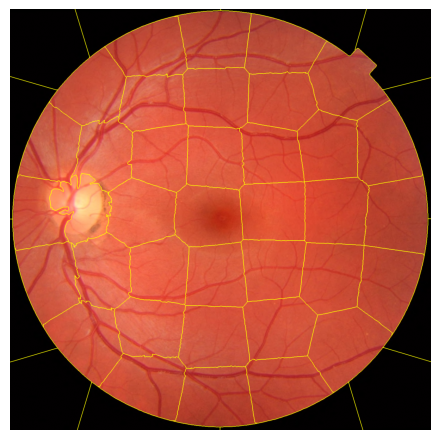

In [26]:
img = img_as_ubyte(retina())
superpixels = build_superpixels_from_image(img, n_segments=53, compactness=40, sigma=0.3)
ax = plt.imshow(mark_boundaries(img, superpixels))
plt.tight_layout()
plt.axis('off')

# Gerar Rede Complexa

(-92.39000000000001, 1502.39, 1502.2849999999999, -91.285)

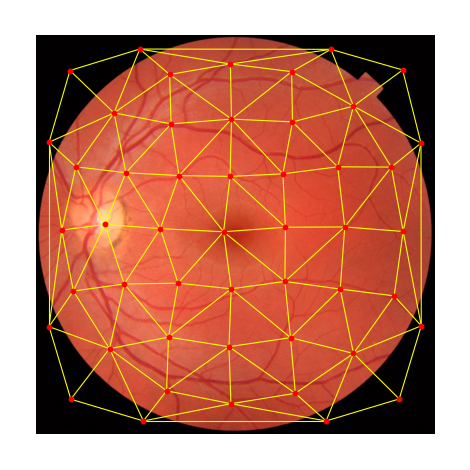

In [27]:
complex_network = complex_network_from_segments(superpixels)
centroids = superpixel_centroids(superpixels)
plt.imshow(img)
draw_complex_network(complex_network, superpixels)
plt.tight_layout()
plt.axis('off')

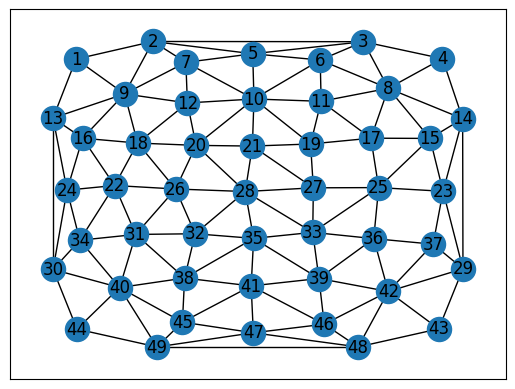

In [28]:
nx.draw_networkx(complex_network, pos=superpixel_centroids(superpixels))
plt.gca().invert_yaxis()
plt.show()

(-92.39000000000001, 1502.39, 1502.2849999999999, -91.285)

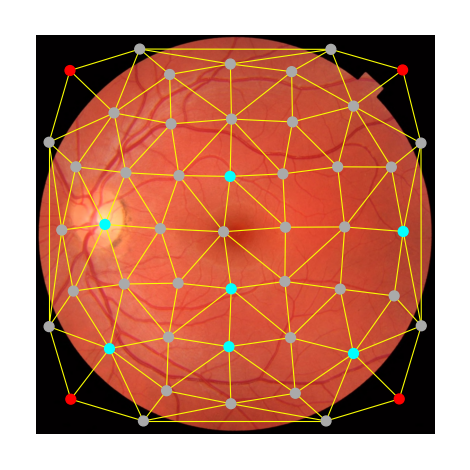

In [29]:
G = complex_network
labels_by_color = {
       1: "#ff0000", # fundo
       2: "#00ffff", # olho
}
superpixel_labels = {
    1:  1,
    4: 1,
    43: 1,
    44: 1,
    41: 2,
    21: 2,
    35: 2,
    22: 2,
    40: 2,
    42: 2,
    23: 2,
}
default = "#aaaaaa"
color_map = [labels_by_color.get(superpixel_labels.get(node), default)
             for node in G.nodes]
for node in G.nodes():
    G.nodes[node]["label"] = superpixel_labels.get(node, 0)
    
plt.imshow(img)
draw_complex_network(G, superpixels, node_size=50, node_color=color_map)
plt.tight_layout()
plt.axis('off')

In [ ]:
X = img
y = np.zeros(shape=superpixels.shape, dtype=np.int64)
for superpixel, label in superpixel_labels.items():
    y[superpixels == superpixel] = label

m = model.EGSIS(
    superpixel_segments=53,
    superpixel_sigma=0.3,
    superpixel_compactness=40,
    feature_extraction="comatrix",
    feature_similarity="euclidian_exp",
)

    
G = m.fit_predict(X, y)


2023-10-01 20:00:06.533 | INFO     | egsis.model:fit_predict:142 - Run!


In [ ]:
default = "#aaaaaa"
color_map = [labels_by_color.get(G.nodes[node].get("label"), default)
             for node in G.nodes]

plt.imshow(img)
draw_complex_network(G, m.segments, node_size=50, node_color=color_map)
plt.tight_layout()
plt.axis('off')

# Extract segmentation mask from special run over EGSIS

In [ ]:
# Fit predict receiving a image mask
mask = m.fit_predict_segmentation_mask(X, y)
mask

In [ ]:
from PIL import ImageColor

labels_by_color = {
       1: "#00ff00", # fundo
       2: "#0000ff", # olho
}

ImageColor.getcolor(labels_by_color[2], "RGB")

In [ ]:
img_mask  = img.copy()
img_mask[mask == 1] = ImageColor.getcolor(labels_by_color[1], "RGB")
img_mask[mask == 2] = ImageColor.getcolor(labels_by_color[2], "RGB")

plt.axis('off')
plt.imshow(img_mask)

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img_mask)
ax[0].set_title("segmentation mask")
ax[1].imshow(img)
ax[1].set_title("original image")

for a in ax.ravel():
    a.set_axis_off()


# Alpha blending: merge image with segmentation mask

In [ ]:
alpha = 0.5
blend = img * (1 - alpha) + img_mask * alpha  
plt.axis('off')
plt.imshow(blend.astype(np.uint8))